# Installation

In [ ]:
!!pip install -q MOABB

In [ ]:
!pip install pywd

In [3]:
import numpy as np
import scipy.signal
import scipy.io as sio
import matplotlib
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import mne
from pywt import wavedec 

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score
# import mlflow
# import mlflow.sklearn

In [4]:
import moabb
from moabb.datasets import EPFLP300, utils
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery
from moabb.pipelines.features import LogVariance
from mne.filter import construct_iir_filter
moabb.set_log_level("info")


import math
from sklearn.metrics import confusion_matrix

In [5]:
import datetime as dt
import glob
import os
import zipfile

import mne
import numpy as np
from mne.channels import make_standard_montage
from scipy.io import loadmat

from moabb.datasets import download as dl
from moabb.datasets.base import BaseDataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Trails

## **Starting clean**


In [8]:
class Normalize:
    def __init__(self):
        self.min = []    # minimal amplitude for all EEG channels
        self.max = []    # maximal amplitude for all EEG channels
        self.mean = []   # mean amplitude for all EEG channels
        self.std = []    # standard deviation for all EEG channels
        self.method = '' # normalization method "minmax" or "z-score"

    def apply(self,n, x):
        # normalization procedure for EEG data
        # uses minima and maxima or means and standard deviations stored in
        # the object n

        n_channels, n_samples, n_trials = x.shape
        x = x.reshape(n_channels, n_samples * n_trials)

        if n.method == 'minmax':
            x = x - np.tile(n.min, (n_samples * n_trials, 1)).T
            x = x / np.tile(n.max - n.min, (n_samples * n_trials, 1)).T
            x = 2 * x - np.ones((n_channels, n_samples * n_trials))

        elif n.method == 'z-score':
            x = x - np.tile(n.mean, (n_samples * n_trials, 1)).T
            x = x / np.tile(n.std, (n_samples * n_trials, 1)).T

        else:
            print('unknown normalization method')

        x = x.reshape(n_channels, n_samples, n_trials)
        return x
    def train(self,n, x, method):
        """
        training procedure for normalize
        computes minima and maxima, or means and standard deviations for 
        normalization of EEG channels

        INPUT:
            n       - object of type normalize
            x       - m*n*t matrix containing t EEG trials with m channels and 
                      n samples
            method  - either 'minmax' or 'z-score'

        OUTPUT:
            n       - updated object of type normalize
        """
        n_channels = x.shape[0]
        n_samples = x.shape[1]
        n_trials = x.shape[2]
        x = x.reshape(n_channels, n_samples * n_trials)

        if method == 'minmax':
            n.min = np.min(x, axis=1)
            n.max = np.max(x, axis=1)
            n.method = 'minmax'
        elif method == 'z-score':
            n.mean = np.mean(x, axis=1)
            n.std = np.std(x, axis=1)
            n.method = 'z-score'
        else:
            print('unknown normalization method')

        return n


In [9]:
class windsor:
    def __init__(self):
        # constructor for class windsor
        # windsor can be used to "windsorize" EEG data

        # METHODS:
        #       train - computes percentiles of EEG channels
        #       apply - clips samples with amplitudes smaller or bigger than
        #               previously computed percentiles

        # Author: Ulrich Hoffmann - EPFL, 2006

        self.limit_l = []  # (lower) percentiles for each EEG channel
        self.limit_h = []  # (upper) percentiles for each EEG channel

    def apply(self, w, x):
        # windsorizes the data in x
        # this means that values that are smaller or bigger than the percentile
        # values in w.limit_l and w.limit_h are clipped

        # INPUT:
        #    w       - object of type windsor
        #    x       - m*n*t matrix containing t EEG trials with m channels and
        #              n samples

        # OUTPUT:
        #    x       - x windsorized

        # Author: Ulrich Hoffmann - EPFL, 2006

        ## initialize variables
        n_channels = x.shape[0]
        n_samples = x.shape[1]
        n_trials = x.shape[2]

        ## clip the data
        x = x.reshape(n_channels, n_samples * n_trials)
        w.limit_l=np.array(w.limit_l)
        w.limit_h=np.array(w.limit_h)
        l = np.tile(w.limit_l.reshape(-1, 1), (1, n_samples * n_trials))
        h = np.tile(w.limit_h.reshape(-1, 1), (1, n_samples * n_trials))
        i_l = x < l
        i_h = x > h
        x[i_l] = l[i_l]
        x[i_h] = h[i_h]
        x = x.reshape(n_channels, n_samples, n_trials)

        return x

    def train(self, w, x, p):
        # computes percentiles for windsorizing

        # INPUT:
        #    w       - object of type windsor
        #    x       - m*n*t matrix containing t EEG trials with m channels and
        #              n samples
        #    p       - percentage of samples that will be clipped from each channel

        # OUTPUT:
        #    w       - updated object of type windsor

        # Author: Ulrich Hoffmann - EPFL, 2006

        ## initialize variables
        n_channels = x.shape[0]
        n_samples  = x.shape[1]
        n_trials   = x.shape[2]
        n_clip     = round(n_samples*n_trials*p/2)
        x = np.reshape(x, (n_channels, n_samples*n_trials))
        w.limit_l = []
        w.limit_h = []

        ## compute (p/2)th percentiles for each channel
        for i in range(n_channels):
            tmp = np.sort(x[i,:])
            w.limit_l.append(tmp[n_clip])
            w.limit_h.append(tmp[-n_clip+1])

        return w


### **Preprocess Single Subject Data**

In [10]:
import os
import numpy as np
from scipy.signal import butter, filtfilt

n_targets = 0  # keeps track of number of target trials
n_nontargets = 0  # keeps track of nontarget trials

# initialize variables

srate = 2048  # sampling rate of raw data in Hz
reference = [6, 23]  # indices of channels used as reference
filterorder = 3
filtercutoff = [1/1024, 12/1024]
f_b, f_a = scipy.signal.butter(filterorder, filtercutoff ,btype='bandpass')
decimation = 64  # downsampling factor
n_samples = 32  # number of (temporal) samples in a trial
sessions=[]

indir='/content/drive/MyDrive/MNE/MNE-epflp300-data/groups/m/mm/mmspg/www/BCI/p300/subject8'
for session in os.listdir(indir):
  runs = [None] * 6
  i=0
  sessiondir=os.path.join(indir, session)
  for filename in os.listdir(sessiondir):
      if not os.path.isdir(os.path.join(sessiondir, filename)):
          filename = os.path.join(sessiondir, filename)
          f =scipy.io.loadmat(filename)


          # 
          signals = f["data"]
          stimuli = f["stimuli"].squeeze()
          events = f["events"]
          target = f["target"][0][0]
          
          # meta-info from the readme.pdf

          # 1................
          # The last X entries are 0 for all signals. This leads to
          # artifacts when epoching and band-pass filtering the data.
          # Correct the signals for this.
          sig_i = np.where(np.diff(np.all(signals == 0, axis=0).astype(int)) != 0)[0][0]
          signals = signals[:, :sig_i]

          # 2................
          # rereference the data
          n_channels = f['data'].shape[0]
          ref = np.tile(np.mean(f['data'][reference, :], axis=0), (n_channels, 1))
          f['data'] = f['data'] - ref

          # drop the mastoid channels
          f['data'] = f['data'][0:32, :]
          n_channels = f['data'].shape[0]

          # bandpass filter the data (with a forward-backward filter)
          for j in range(n_channels):
              f['data'][j, :] = filtfilt(f_b, f_a, f['data'][j, :])

          # downsample the data (from 2048 Hz to 64 Hz)
          f['data'] = f['data'][:, 0::decimation]

          # extract trials
          # compute class labels
          # put everything in the cell-array runs
          n_trials = f['events'].shape[0]
          runs[i]={'x': np.zeros((n_channels, n_samples, n_trials)), 
                        'y': np.zeros(n_trials),
                        'stimuli': stimuli,
                        'target': target}

          # getting the event time in a Python standardized way
          events_datetime = []
          for eventi in events:
              events_datetime.append(
                  dt.datetime(*eventi.astype(int), int(eventi[-1] * 1e3) % 1000 * 1000)
              )

          # get the indices of the stimuli
          pos = []
          n_trials = len(stimuli)
          for j in range(n_trials):
              delta_seconds = (events_datetime[j] - events_datetime[0]).total_seconds()
              delta_indices = int(delta_seconds * srate/decimation)
              # has to add an offset
              pos.append(delta_indices + int(0.4 * srate/decimation))

          for j in range(n_trials):
              runs[i]['x'][:, :, j] = f['data'][:, pos[j]:pos[j]+n_samples]
          runs[i]['y'][stimuli == target] = 1
          runs[i]['y'][stimuli != target] = -1

          xt=runs[i]['x']
          w = windsor()
          w= w.train(w,xt,0.1)
          x = w.apply(w,xt)

          n= Normalize()
          n= n.train(n,x,'z-score')
          x= n.apply(n,x)
          runs[i]['x']=x

          # update counters
          n_targets += np.sum(runs[i]['y'] == 1)
          n_nontargets += np.sum(runs[i]['y'] == -1)
      i=i+1
  sessions.append(runs)

print(f'total target trials: {n_targets}')
print(f'total nontarget trials: {n_nontargets}')


total target trials: 556
total nontarget trials: 2780


### **Prepare data to be 2D array (n_channels, n_samples) (32,32) array and outputs to be 0 and 1**

In [11]:
def Preprocess(sessions):
  x_train=[]
  y_train=[]

  for session in range(3):
    for run in range(6):
      n_trials=sessions[session][run]['x'].shape[2]
      for trial in range(n_trials):
        x_train.append(sessions[session][run]['x'][:,:,trial])
        if(sessions[session][run]['y'][trial]==1):
          y_train.append(1)
        else:
           y_train.append(0)

  x_test =[]
  y_test =[]
  for run in range(6):
      n_trials=sessions[3][run]['x'].shape[2]
      for trial in range(n_trials):
        x_test.append(sessions[3][run]['x'][:,:,trial])
        if(sessions[3][run]['y'][trial]==1):
          y_test.append(1)
        else:
          y_test.append(0)
  return x_train,y_train, x_test ,y_test

In [12]:
x_train,y_train, x_test ,y_test=Preprocess(sessions)

### **Train DL EEGNet Model**

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans=32, Samples=32):
    # Define the input shape
    input_shape = (Chans, Samples, 1)

    # Define the model architecture
    input_layer = layers.Input(shape=input_shape)

    block1 = layers.Conv2D(16, (1, 32), padding='same', input_shape=input_shape)(input_layer)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.SeparableConv2D(32, (1, 4), use_bias=False, padding='same')(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.MaxPooling2D((1, 4))(block1)
    block1 = layers.Dropout(0.25)(block1)

    block2 = layers.DepthwiseConv2D((1, 4), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.SeparableConv2D(64, (1, 4), use_bias=False, padding='same')(block2)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.MaxPooling2D((1, 2))(block2)
    block2 = layers.Dropout(0.25)(block2)

    flatten = layers.Flatten()(block2)

    dense = layers.Dense(256, activation='elu')(flatten)
    dense = layers.Dropout(0.5)(dense)

    output_layer = layers.Dense(1, activation='sigmoid')(dense)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [14]:
import math
from sklearn.metrics import confusion_matrix

# # Train the model
model = EEGNet(nb_classes=1)
history = model.fit(np.array(x_train), np.array(y_train), epochs=50, batch_size=16, validation_data=(np.array(x_test), np.array(y_test)))

# # Evaluate the model on the test set
# score = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)

# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# cm = confusion_matrix(y_test,predictions,labels=[2,1])
# print(cm)
# print("______________________________________________")

Epoch 1/50
158/158 [==============================] - 11s 49ms/step - loss: 0.5212 - accuracy: 0.8048 - val_loss: 0.5809 - val_accuracy: 0.8333
Epoch 2/50
158/158 [==============================] - 5s 32ms/step - loss: 0.4076 - accuracy: 0.8325 - val_loss: 0.4165 - val_accuracy: 0.8407
Epoch 3/50
158/158 [==============================] - 7s 47ms/step - loss: 0.3135 - accuracy: 0.8729 - val_loss: 0.3617 - val_accuracy: 0.8679
Epoch 4/50
158/158 [==============================] - 9s 54ms/step - loss: 0.2896 - accuracy: 0.8880 - val_loss: 0.3319 - val_accuracy: 0.8593
Epoch 5/50
158/158 [==============================] - 7s 46ms/step - loss: 0.2445 - accuracy: 0.9058 - val_loss: 0.3320 - val_accuracy: 0.8642
Epoch 6/50
158/158 [==============================] - 6s 37ms/step - loss: 0.2262 - accuracy: 0.9105 - val_loss: 0.2917 - val_accuracy: 0.8914
Epoch 7/50
158/158 [==============================] - 5s 33ms/step - loss: 0.1868 - accuracy: 0.9252 - val_loss: 0.3159 - val_accuracy: 0.891

In [15]:
import seaborn as sns
def plot_confusion_matrix(x,y,model):
  Y_pred = model.predict(x)
  Y_pred_classes = Y_pred.round()
  confusion_mtx = confusion_matrix(y, Y_pred_classes) 
  f,ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

26/26 [==============================] - 1s 16ms/step


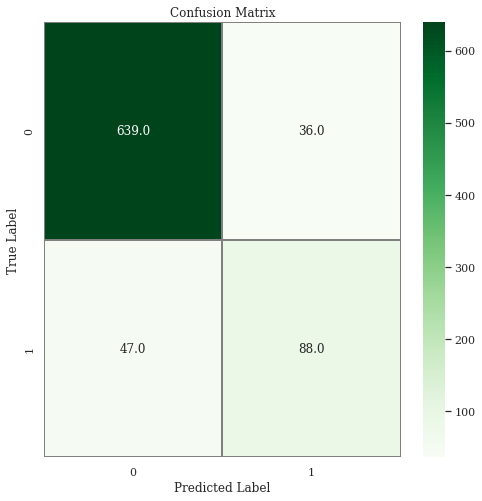

In [16]:
plot_confusion_matrix(np.array(x_test),np.array(y_test),model)

### **This is the same preprocessing cell, Bult altered a little bit to represent single trail as a 1D feature vector for ML models**

In [17]:
def Preprocess(sessions):
  x_train=[]
  y_train=[]

  for session in range(3):
    for run in range(6):
      n_trials=sessions[session][run]['x'].shape[2]
      for trial in range(n_trials):
        featureVector=[]
        for i in range(32):
          featureVector.extend(sessions[session][run]['x'][:,i,trial])
        x_train.append(featureVector)
        y_train.append(sessions[session][run]['y'][trial])

  x_test =[]
  y_test =[]
  for run in range(6):
      n_trials=sessions[3][run]['x'].shape[2]
      for trial in range(n_trials):
        featureVector=[]
        for i in range(32):
          featureVector.extend(sessions[3][run]['x'][:,i,trial])
        x_test.append(featureVector)
        y_test.append(sessions[3][run]['y'][trial])
  return x_train,y_train, x_test ,y_test

In [18]:
x_train,y_train, x_test ,y_test=Preprocess(sessions)

In [19]:
YTrain=[]
for i in y_train:
  if(i==1.0):
    YTrain.append(2)
  else:
    YTrain.append(1)

In [20]:
YTest=[]
for i in y_test:
  if(i==1.0):
    YTest.append(2)
  else:
    YTest.append(1)

### **Training SVM**

In [26]:
subjectNumber=8
print("preparing Subject ",subjectNumber , " Data.......")
clf = svm.SVC()
clf.fit(x_train,YTrain)
predictions =clf.predict(x_test)
print(subjectNumber , "accuracy score " , accuracy_score(predictions , YTest))

preparing Subject  8  Data.......
8 accuracy score  0.8851851851851852


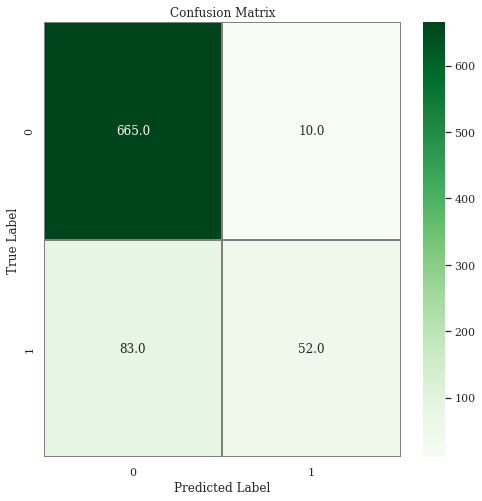

In [27]:
plot_confusion_matrix(np.array(x_test),np.array(YTest),clf)

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

blda = LinearDiscriminantAnalysis()
blda.fit(x_train,YTrain)
preditions =blda.predict(x_test)
print(subjectNumber , "accuracy score " , accuracy_score(preditions , YTest))

8 accuracy score  0.8888888888888888


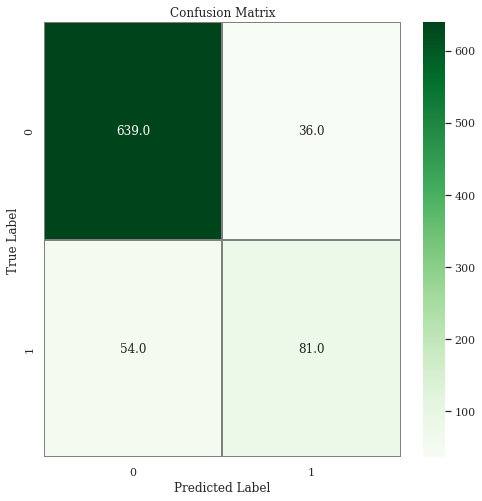

In [31]:
plot_confusion_matrix(np.array(x_test),np.array(YTest),blda)

### **This is an unused cell. it could be used, it couldn't, we do not know**

In [ ]:
class bayeslda:
    def __init__(self, verbose=False):
        # set verbose flag
        self.verbose = verbose  # if set train gives verbose output

        # define attributes of object
        self.evidence = 0  # log evidence
        self.beta = 0  # inverse variance of noise
        self.alpha = 0  # inverse variance of prior
        self.w = []  # weight vector (mean of posterior)
        self.p = []  # precision matrix of posterior

    # METHODS
    def train(b, x, y):
        """
        Training procedure for Bayesian LDA
        
        INPUT:
            b: object of type bayeslda
            x: m*n matrix containing n feature vectors of size m*1
            y: 1*n matrix containing class labels (-1,1)
        
        OUTPUT:
            b: updated object of type bayeslda
        """
        n_posexamples = sum(y==1)
        n_negexamples = sum(y==-1)
        n_examples = n_posexamples + n_negexamples
        y[y==1] = n_examples/n_posexamples
        y[y==-1] = -n_examples/n_negexamples

        x = np.vstack([x, np.ones((1, x.shape[1]))]) # stack ones row to x

        n_features = x.shape[0] # dimension of feature vectors 
        d_beta = np.inf # (initial) diff. between new and old beta  
        d_alpha = np.inf # (initial) diff. between new and old alpha 
        alpha = 25 # (initial) inverse variance of prior distribution
        biasalpha = 0.00000001 # (initial) inverse variance of prior for bias term
        beta = 1 # (initial) inverse variance around targets
        stopeps = 0.0001 # desired precision for alpha and beta
        i = 1 # keeps track of number of iterations
        maxit = 500 # maximal number of iterations 
        v, d = np.linalg.eig(np.dot(x, x.T)) # needed for fast estimation of alpha and beta  
        vxy = np.dot(v.T, np.dot(x, y.T)) # dito
        d = np.diag(d) # dito
        e = np.ones((n_features-1,1)) # dito

        while ((d_alpha > stopeps) or (d_beta > stopeps)) and (i < maxit):
            alphaold = alpha
            betaold = beta
            m = beta * v * (beta * d + np.vstack([alpha * e, biasalpha]) ** (-1) * vxy)
            err = np.sum((y - np.dot(m.T, x)) ** 2)
            gamma = np.sum(beta * d / (beta * d + np.vstack([alpha * e, biasalpha])))
            alpha = gamma / np.dot(m.T, m)
            beta = (n_examples - gamma) / err
            if b.verbose:
                print(f"Iteration {i}: alpha = {alpha}, beta = {beta}")
            d_alpha = np.abs(alpha - alphaold)
            d_beta = np.abs(beta - betaold)
            i += 1

        if i < maxit:
            # (see MacKays paper)
            b.evidence = (n_features / 2) * np.log(alpha) + (n_examples / 2) * np.log(beta) - \
                (beta / 2) * err - (alpha / 2) * np.dot(m.T, m) - \
                0.5 * np.sum(np.log((beta * d + np.vstack([alpha * e, biasalpha])))) - (n_examples / 2) * np.log(2 * np.pi)

            b.alpha = alpha
            b.beta = beta
            b.w = m
            b.p = np.dot(v, np.diag((beta * d + np.vstack([alpha * e, biasalpha])) ** (-1))) @ v.T

            if b.verbose:
                print("Optimization of alpha and beta successful.")
                print(f"The logevidence is {b.evidence}.")

        else:
            print(f"Optimization of alpha and beta did not converge after {maxit} iterations.")
            print("Giving up.")


    def classify(self, x):
        pass

    def getevidence(self):
        pass
